# Demodulación FM de muestras IQ de RTL-SDR v3

In [5]:
import time
from rtlsdr import RtlSdr
import numpy as np  
import scipy.signal as signal
from scipy.io import wavfile
from typing import List
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
F_station = int(137.5e6)   # Frecuencia de la estación transmisora
F_offset = 0       # Desplazamiento para capturar en  
# Capturamos en un offset para evitar picos de CC (DC)
Fc = F_station - F_offset # Captura de la frecuencia central  
Fs = int(0.230e6)         # Frecuencia de muestreo  

sdr = RtlSdr()
# Configurar dispositivo
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'
sdr.bw = 115e3
all_samples = []
async def streaming(sdr: RtlSdr, time_s: int) -> List[np.ndarray]:
    # all_samples = []
    global all_samples
    t_before = time.time()
    print("Recepcionando muestras...")
    async for samples in sdr.stream():
        all_samples.append(samples)
        if time.time() - t_before >= time_s:
            break
    # configurar dispositivo
    await sdr.stop()
    sdr.close()
    return all_samples


In [12]:
# Leer muestras hasta que pase cierto tiempo
tiempo_a_recepcionar = 209  # Tiempo en segundos

samples = await streaming(sdr, tiempo_a_recepcionar)
print('Listo!')

Recepcionando muestras...
Listo!


In [13]:
# Limpiar el dispositivo SDR
sdr.close()
del(sdr)

In [14]:
# Convertir muestras en una matriz numpy
x1 = np.array(all_samples).ravel().astype("complex64")

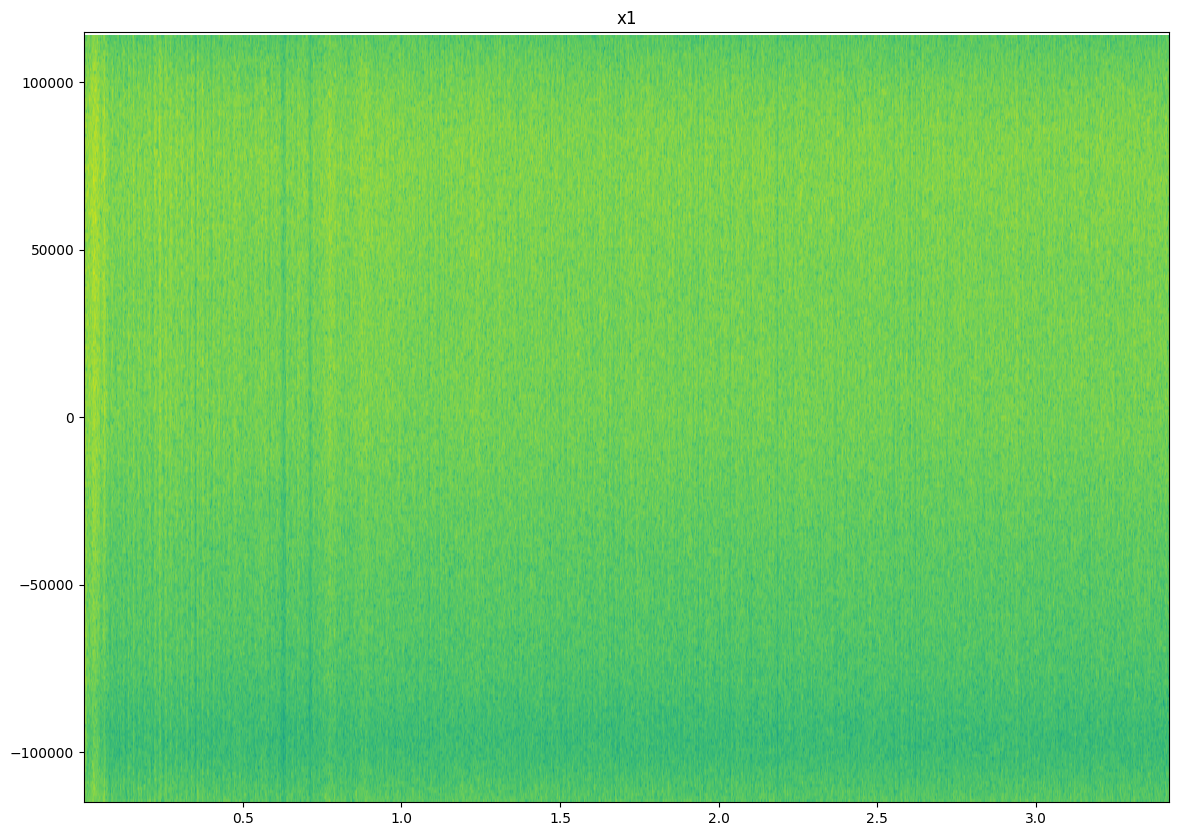

In [15]:
plt.figure(figsize=(14,10))
plt.specgram(x1, NFFT=256, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2)  
plt.show()

In [16]:
# Para mezclar los datos hacia abajo, generar una exponencial compleja digital 
# (con la misma longitud que x1) con fase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))

# Ahora, basta con multiplicar x1 y el exponencial complejo digital
x2 = x1 * fc1  

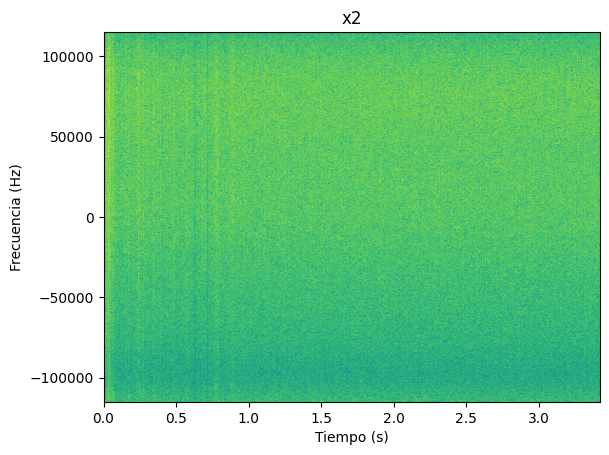

In [29]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Tiempo (s)")  
plt.ylabel("Frecuencia (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

In [17]:
# Una señal de radiodifusión en FM tiene un ancho de banda de 200 kHz.
f_bw = 115000  # 115 KHz para APT_Tx
dec_rate = int(Fs / f_bw)  
x4 = signal.decimate(x2, dec_rate)  
# Calcular la nueva frecuencia de muestreo
Fs_y = Fs/dec_rate  

In [18]:
Fs_y

115000.0

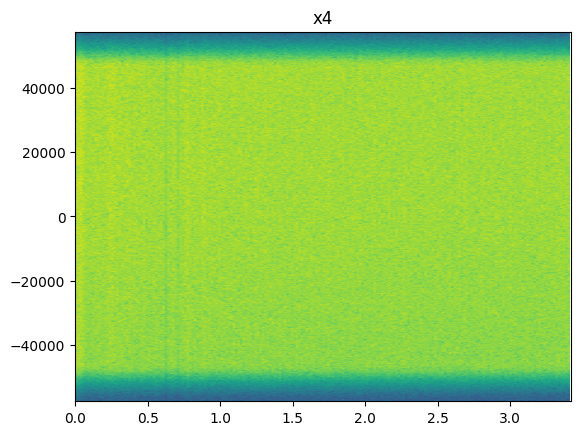

In [19]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

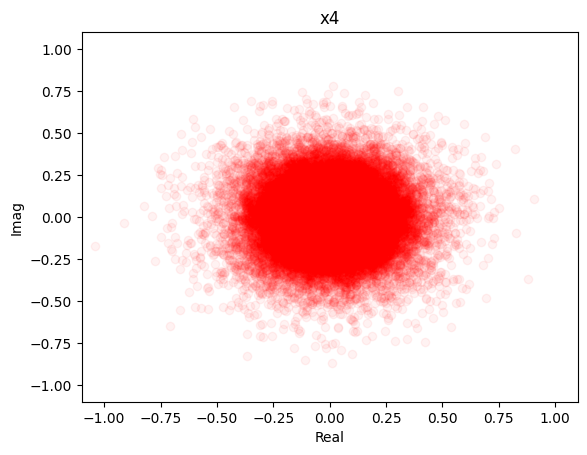

In [20]:
# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
plt.show()

In [21]:
### Discriminador polar
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

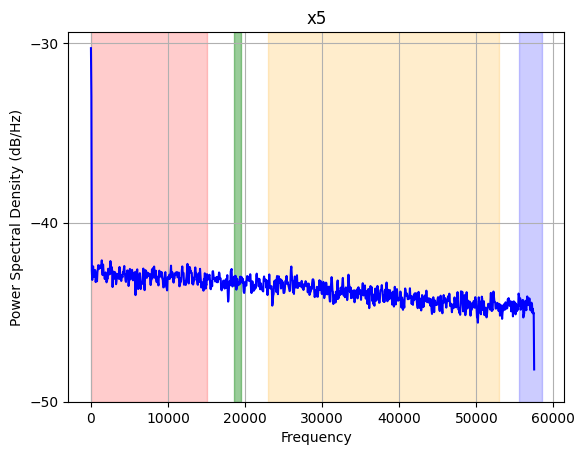

In [22]:
# Nota: x5 es ahora una matriz de valores reales, no complejos
# Como resultado, las PSD se trazarán por defecto en un solo lado (ya que
# una señal real tiene un espectro simétrico)
# Trazar la PSD de x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.axvspan(19000-500, 19000+500, color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500, 19000*3+1500, color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  


In [23]:
# El filtro de desacentuación
# Dada una señal 'x5' (en un array numpy) con frecuencia de muestreo Fs_y
d = Fs_y * 75e-6   # Calcular el número de muestras para alcanzar el punto -3dB  
x = np.exp(-1/d)   # Calcular el decaimiento entre cada muestra  
b = [1-x]          # Crear los coeficientes del filtro  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

In [24]:
# Encuentra una tasa de decimación para conseguir una frecuencia de muestreo de audio entre 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

In [25]:
audio_freq

44100.0

In [26]:
# Escala el audio para ajustar el volumen
x7 *= 10000 / np.max(np.abs(x7))  
# Guardar en archivo como muestras de audio monocanal con signo de 16 bits
# x7.astype("int16").tofile("./Files_Rx/wbfm-mono_Rx.raw")

In [27]:
print(Fs_audio) 

57500.0


In [28]:
# Guardar como archivo de audio en formato 16-bit PCM RIFF WAV
wavfile.write('./Files_Rx/audio_APT_Rx_pyfm.wav', int(Fs_audio), x7.astype("int16"))